# Slide Graph Pipeline

Click to open in: [[GitHub](https://github.com/TissueImageAnalytics/tiatoolbox/tree/master/examples/inference-pipelines/slide-graph.ipynb)][[Colab](https://colab.research.google.com/github/TissueImageAnalytics/tiatoolbox/blob/master/examples/inference-pipelines/slide-graph.ipynb)][[Kaggle](https://kaggle.com/kernels/welcome?src=https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/examples/inference-pipelines/slide-graph.ipynb)]


_In order to run this notebook on a Kaggle platform, 1) click the Kaggle URL 2) click on Settings on the right of the Kaggle screen, 3) log in to your Kaggle account, 4) tick "Internet" checkbox under Settings, to enable necessary downloads._

> **Note**: This notebook is computationally intensive. We advise users to run this
> notebook with GPUs. In order to use the GPUs in Colab and Kaggle, do the the followings
> before any installation:
> - Colab: Menu bar > Runtime > Change Runtime Type > Hardware Accelerator > Click GPU option.
> - Kaggle: Navigate to the “Settings” pane from the Notebook editor (on the right)
> and click the “Accelerator" > GPU option.

## About this notebook
This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory or Kaggle. To connect with Colab or Kaggle, click on one of the URLs above. Check that "colab" or "kaggle", as appropriate, appears in the address bar. You can right click on "Open in Colab" and select "Open in new tab" if left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on GitHub, Colab or Kaggle, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab or Kaggle, set up your Python environment, as explained in the
[README](https://tia-toolbox.readthedocs.io/en/develop/installation.html) file.

## Introduction

> **Note**: This notebook is aimed at advanced users who are interested in using
> TIAToolbox as part of an experiment or larger project.

<br/>

> **Note**: This notebook is a simplified inference portion of a larger notebook
> which is available here [Slide Graph Pipeline](https://github.com/TissueImageAnalytics/tiatoolbox/tree/example-slide-graph-pipeline/examples/full-pipelines/slide-graph.ipynb). This larger notebook contains
> a full pipeline (training and inference) to reproduce the results of the method
> referenced here.

Here we demonstrate how the inference in the method of
"SlideGraph+: Whole Slide Image Level Graphs to Predict HER2Status
in Breast Cancer" by Lu et al. (2021) can be done using the functionalities
available in TIAToolbox. As a brief overview, this method involves generating
a graph to represent a whole slide image (WSI) level and then directly using
it as input to predict a slide level label. For this notebook, our task is
to classify a whole slide image (WSI) as [HER2](https://en.wikipedia.org/wiki/HER2/neu)
negative or positive. We will use a sample WSI from [TCGA-BRCA](https://portal.gdc.cancer.gov/projects/TCGA-BRCA)
and a model pretrained on the [TCGA-BRCA](https://portal.gdc.cancer.gov/projects/TCGA-BRCA) dataset.

Throughout this notebook we use modules from TIAToolbox to assist with standard tasks including:
- Patch extraction
- Stain normalization
- Cell segmentation & classification
- Extraction of deep features
- Graph Construction
- Graph Plotting

> **Note**: Although the original paper was evaluated for HER2. The method itself
> can be applicable for other mutation prediction. We provide a pretrained model
> for predicting [ER (Estrogen receptor)](https://en.wikipedia.org/wiki/Estrogen_receptor)
> status [here (model weights)](https://tiatoolbox.dcs.warwick.ac.uk/models/slide_graph/deep-features/model.weights.pth)
> and [here (model auxiliary)](https://tiatoolbox.dcs.warwick.ac.uk/models/slide_graph/deep-features/model.aux.dat).
> You can get the pre-generated graphs [here](https://tiatoolbox.dcs.warwick.ac.uk/models/slide_graph/deep-features/graphs.zip)
> and its node preprocessing model [here](https://tiatoolbox.dcs.warwick.ac.uk/models/slide_graph/deep-features/node_scaler.dat).
> For predicting ER status, we use deep features coming from ResNet50 rather than
> the cellular composition.


You can skip the following cell if 1) you are not using the Colab or Kaggle platforms or 2) you are using Colab or Kaggle and this is not your first run of the notebook in the current session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab or Kaggle the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab or Kaggle, the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install tiatoolbox | tail --line 1

Running the following cell will install the Cuda enabled version of the torch
package to utilize GPU computation and speed up the TIAToolbox > models.

> **Note**: After installation, users need to reset their run time environment
> to load the correct libraries. This option can be found in the Menu bar > Run time.
> You can skip the following cell after resetting.

In [5]:
ON_GPU = True
!pip install -U numpy
!pip install umap-learn
!pip uninstall -y torch
!pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-geometric

Found existing installation: torch 1.10.0
Uninstalling torch-1.10.0:
  Successfully uninstalled torch-1.10.0
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu113/torch-1.10.0%2Bcu113-cp38-cp38-linux_x86_64.whl (1821.4 MB)
  Using cached torch_scatter-2.0.9.tar.gz (21 kB)
  Using cached torch_sparse-0.6.12.tar.gz (43 kB)
  Using cached torch_cluster-1.5.9.tar.gz (38 kB)
  Using cached torch_spline_conv-1.2.1.tar.gz (13 kB)
  Using cached torch_geometric-2.0.2-py3-none-any.whl
anceled
ERROR: Operation cancelled by user


## Preparation: Imports, Helpers, & Data Split

We begin by importing some libraries, defining some helper functions
and defining how we will split the dataset into train, validation, and test sets.

### Import Libraries

In [2]:
# Python standard library imports
import copy
import os
import pathlib
import random
import shutil
import warnings
from collections import OrderedDict
from typing import Callable, List, Tuple

# Third party imports
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import json

warnings.filterwarnings("ignore")

import sys

# ! save_yaml, save_as_json => need same name, need to factor out jsonify
from tiatoolbox.utils.misc import download_data, imread, save_as_json

mpl.rcParams['figure.dpi'] = 300  # for high resolution figure in notebook


### Helper Functions

Here we define some helper functions that will be used throughout the notebook:

In [4]:
def load_json(path: str):
    """Load JSON from a file path."""
    with open(path, "r") as fptr:
        json_dict = json.load(fptr)
    return json_dict


def rmdir(dir_path: str):
    """Remove a directory."""
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
    return


def rm_n_mkdir(dir_path: str):
    """Remove then re-create a directory."""
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)
    return


def mkdir(dir_path: str):
    """Create a directory if it does not exist."""
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    return


## Fixing Randomness
We fix the random generator to 1) make debugging easier, and 2) enable us to test whether our pipeline has the same properties as the pipeline that we are trying to reproduce. (For this comparison to work, the original pipeline needs to be constructed using the same random seed.)

In [5]:
SEED = 5
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Loading Data
Here we define the sample data used for this notebook.
By default, the code checks for the existence of the folder DOWNLOAD_DIR.
If this folder does not exist, the code will download the data that we prepared beforehand.
If you want to store the intermediate results at a different location,
you need to edit `WORKSPACE_DIR` accordingly.

Other than that, the pre-trained models can be found using the following path variables,
giving locations of models described in the larger notebook mentioned previously:
- `SCALER_PATH`: The model to standardize the features of each node within the WSI graph.
- `MODEL_WEIGHTS_PATH`: The weights of the graph neural network.
- `MODEL_AUX_PATH`: The model to calibrate the model predictions into proper probabilities.

In [6]:
WORKSPACE_DIR = "workspace"
DOWNLOAD_DIR = f"{WORKSPACE_DIR}/download/"

WSI_PATH = f"{DOWNLOAD_DIR}/sample.svs"
MSK_PATH = f"{DOWNLOAD_DIR}/sample_mask.png"
PRE_GENERATED_GRAPH_PATH = f"{DOWNLOAD_DIR}/graph.json"
SCALER_PATH = f"{DOWNLOAD_DIR}/node_scaler.dat"
MODEL_WEIGHTS_PATH = f"{DOWNLOAD_DIR}/model.weigths.pth"
MODEL_AUX_PATH = f"{DOWNLOAD_DIR}/model.aux.dat"

In [7]:

# ! Uncomment this to always download data
rmdir(DOWNLOAD_DIR)

# Downloading sample image tile
if not os.path.exists(DOWNLOAD_DIR):
    mkdir(DOWNLOAD_DIR)
    URL_HOME = "https://tiatoolbox.dcs.warwick.ac.uk/models/slide_graph/cell-composition"
    SLIDE_CODE = "TCGA-C8-A278-01Z-00-DX1.188B3FE0-7B20-401A-A6B7-8F1798018162"
    download_data(f"{URL_HOME}/{SLIDE_CODE}.svs", WSI_PATH)
    download_data(f"{URL_HOME}/{SLIDE_CODE}.mask.png", MSK_PATH)
    download_data(f"{URL_HOME}/{SLIDE_CODE}.json", PRE_GENERATED_GRAPH_PATH)
    download_data(f"{URL_HOME}/node_scaler.dat", SCALER_PATH)
    download_data(f"{URL_HOME}/model.aux.dat", MODEL_AUX_PATH)
    download_data(f"{URL_HOME}/model.weights.pth", MODEL_WEIGHTS_PATH)

## Generating a Graph from a WSI

> **Note**: If you do not want to construct the graphs and only want to try out the graph neural
> network portion, we provide pre-generated graphs based on cell-composition features extracted from
> HoVer-Net at this [link](https://tiatoolbox.dcs.warwick.ac.uk/models/slide_graph/cell-composition/graphs.zip).
> After downloading and extracting them, please follow the instructions below for how to proceed
> after the graphs have been constructed.

We represent each WSI as a graph. Each node in the graph corresponds
to one local region (such as image patch) within the WSI and is then
represented by a set of features. Here, we describe two possible alternative
feature representations, that have been found to be useful. Users might want
to use other feature representations different from both of these:
-	Deep Neural Network features: obtained from the global average pooling layer after
we apply ResNet50 on the image patch.
-	Cellular composition: where we count the number of nuclei of each type within the patch.
The pre-trained model (HoVer-Net trained on Pannuke), available from  TIAToolbox,
recognizes the following nucleus types: neoplastic, non-neoplastic epithelial,
inflammatory, connective tissue and necrotic.

With these node-level representations (or features), we then perform clustering so that nodes that are close to each other both in feature space and in the 2D space (i.e the WSI canvas) are assigned to the same cluster. These clusters are then linked to other clusters within a certain distance, thus giving a WSI graph.

> **Note**: Features of patches and their positions within each WSI will be stored
> separately in files named `*.features.npy` and `*.position.npy*`. The `position` of a feature is,
> by definition, the patch bounding box `(start_x, start_y, end_x, end_y)` at the highest
> resolution. Subsequent function definitions will be based upon this convention.

### Deep Feature Extraction

We now show how to use the toolbox to extract features. For better organization, we package
the task into a small function called `extract_deep_features`.

In this function, we construct the config object which defines the shape and magnification of the
patch we want to extract. Although the patches are allowed to have arbitrary size and differing
resolutions, here we use a patch of size 512x512 with 0.25 microns-per-pixel (`mpp=0.25`).
We use ResNet50 trained on ImageNet as a feature extractor. For more
detail on how to further customize this, you can refer to [this notebook](https://github.com/TissueImageAnalytics/tiatoolbox/tree/master/examples/07-advanced-modeling.ipynb).

We explain how to construct a customized preprocessing function that we would like
the `engine` to perform on each input patch. (By an engine, we mean one of the top
level classes defined in one of the functions in the module tiatoolbox.models.engine.
Each instance of such a class has multiple properties and abilities, possibly
incorporating several functions.) For this notebook, we perform stain-normalization
on each image patch. Later we show how this function can be defined.

By default, the names of output files from the toolbox are
changed to sequentially ordered names `(000.*.npy, 001.*.npy, etc.)` to avoid
inadvertent overwriting. A mapping from output path name to input path name
is returned by the engine, making the name change easy to manage.

In this demo, we use a toolbox model with only one head (output channel).
For each input, we obtain files `*.position.npy` and `*.features.0.npy`.
(The wildcards ‘*’ are, by default replaced by sequentially ordered names as just explained.)
In the case of models having multiple output heads (output channels), the output is
`['*.position.npy', '*.features.0.npy', '*.features.1.npy', etc.]`.
The positions are always defined as the patch bounding box `(start_x, start_y, end_x, end_y)`
at the highest resolution within the list of input resolutions.
Refer to the [semantic segmentation notebook](https://github.com/TissueImageAnalytics/tiatoolbox/tree/master/examples/06-semantic-segmentation.ipynb)) for details.

In [8]:
from tiatoolbox.models import DeepFeatureExtractor, IOSegmentorConfig
from tiatoolbox.models.architecture import CNNBackbone


def extract_deep_features(
        wsi_paths: List[str],
        msk_paths: List[str],
        save_dir: str,
        preproc_func: Callable = None):
    ioconfig = IOSegmentorConfig(
        input_resolutions=[
            {"units": "mpp", "resolution": 0.25},
        ],
        output_resolutions=[
            {"units": "mpp", "resolution": 0.25},
        ],
        patch_input_shape=[512, 512],
        patch_output_shape=[512, 512],
        stride_shape=[512, 512],
        save_resolution={"units": "mpp", "resolution": 8.0},
    )
    model = CNNBackbone("resnet50")
    extractor = DeepFeatureExtractor(
        batch_size=32, model=model, num_loader_workers=4)
    # Injecting customized preprocessing functions,
    # check the document or sample code below for API.
    extractor.model.preproc_func = preproc_func

    rmdir(save_dir)
    output_map_list = extractor.predict(
        wsi_paths,
        msk_paths,
        mode="wsi",
        ioconfig=ioconfig,
        on_gpu=True,
        crash_on_exception=True,
        save_dir=save_dir,
    )

    # Rename output files
    for input_path, output_path in output_map_list:
        input_name = pathlib.Path(input_path).stem

        output_parent_dir = pathlib.Path(output_path).parent

        src_path = pathlib.Path(f'{output_path}.position.npy')
        new_path = pathlib.Path(f'{output_parent_dir}/{input_name}.position.npy')
        src_path.rename(new_path)

        src_path = pathlib.Path(f'{output_path}.features.0.npy')
        new_path = pathlib.Path(f'{output_parent_dir}/{input_name}.features.npy')
        src_path.rename(new_path)

    return output_map_list

### Cell Composition Extraction

In a similar manner, we define the code to extract cell
composition in `extract_composition_features`. First, we need to
detect all nuclei in the WSI and their types. This can be
easily achieved via the `tiatoolbox.models.NucleusInstanceSegmentor`
engine and the HoVer-Net pretrained model, both provided in the toolbox.
Once we have the nuclei, we split the WSI into patches
and count the nuclei of each type in each patch.
We encapsulate this process in the function `get_composition_features`.

Unlike the `DeepFeatureExtractor` above, the `NucleusInstanceSegmentor` engine
returns a single output file given a single WSI input. The corresponding output
files are named as `['*/0.dat', '*/1.dat', etc.]`. Each of these `.dat` files is used to generate
two files named `*.features.npy` and `*.position.npy`. As in the case of `DeepFeatureExtractor`,
the wildcard _* is, by default, replaced by sequentially ordered names,
for easier management and to avoid inadvertent overwriting.

In [9]:
from tiatoolbox.wsicore.wsireader import get_wsireader
from tiatoolbox.models import NucleusInstanceSegmentor
from tiatoolbox.tools.patchextraction import PatchExtractor
from shapely.geometry import box as shapely_box
from shapely.strtree import STRtree


def get_cell_compositions(
            wsi_path: str,
            inst_pred_path: str,
            save_dir: str,
            num_types: int = 6,
            patch_input_shape: Tuple[int] = (512, 512),
            stride_shape: Tuple[int] = (512, 512),
            resolution: float = 0.25,
            units: str = 'mpp',
        ):
    """
    Args:
        out_path (str): Path pointing to file containing nucleus
            instance predictions, assumed to be from tiatoolbox.

    """

    reader = get_wsireader(wsi_path)
    inst_pred = joblib.load(inst_pred_path)
    # Convert to {key: int, value: dict}
    inst_pred = {
        i: v for i, (_, v) in enumerate(inst_pred.items())
    }

    inst_boxes = [v['box'] for v in inst_pred.values()]
    inst_boxes = np.array(inst_boxes)

    geometries = [shapely_box(*bounds) for bounds in inst_boxes]
    # An auxiliary dictionary to actually query the index within the source list
    index_by_id = {id(geo): idx for idx, geo in enumerate(geometries)}
    spatial_indexer = STRtree(geometries)

    # * Generate patch coordinates (in xy format)
    wsi_shape = reader.slide_dimensions(resolution=resolution, units=units)

    (patch_inputs, _) = PatchExtractor.get_coordinates(
        image_shape=wsi_shape,
        patch_input_shape=patch_input_shape,
        patch_output_shape=patch_input_shape,
        stride_shape=stride_shape,
    )

    bounds_compositions = []
    for bounds in patch_inputs:
        bounds_ = shapely_box(*bounds)
        indices = [
            index_by_id[id(geo)]
            for geo in spatial_indexer.query(bounds_)
            if bounds_.contains(geo)
        ]
        insts = [inst_pred[v]['type'] for v in indices]
        uids, freqs = np.unique(insts, return_counts=True)
        # A bound may not contain all types, hence, to sync
        # the array and placement across all types, we create
        # a holder then fill the count within.
        holder = np.zeros(num_types, dtype=np.int16)
        holder[uids] = freqs
        bounds_compositions.append(holder)
    bounds_compositions = np.array(bounds_compositions)

    base_name = pathlib.Path(wsi_path).stem
    # Output in the same saving protocol for construct graph
    np.save(f'{save_dir}/{base_name}.position.npy', patch_inputs)
    np.save(f'{save_dir}/{base_name}.features.npy', bounds_compositions)


def extract_composition_features(
        wsi_paths: List[str],
        msk_paths: List[str],
        save_dir: str,
        preproc_func: Callable):
    inst_segmentor = NucleusInstanceSegmentor(
        pretrained_model="hovernet_fast-pannuke",
        batch_size=16,
        num_postproc_workers=2,
    )
    # Injecting customized preprocessing functions,
    # check the document or sample codes below for API
    inst_segmentor.model.preproc_func = preproc_func

    rmdir(save_dir)
    output_map_list = inst_segmentor.predict(
        wsi_paths,
        msk_paths,
        mode="wsi",
        on_gpu=True,
        crash_on_exception=True,
        save_dir=save_dir,
    )
    # Rename output files of toolbox
    output_paths = []
    for input_path, output_path in output_map_list:
        input_name = pathlib.Path(input_path).stem

        output_parent_dir = pathlib.Path(output_path).parent

        src_path = pathlib.Path(f'{output_path}.dat')
        new_path = pathlib.Path(f'{output_parent_dir}/{input_name}.dat')
        src_path.rename(new_path)
        output_paths.append(new_path)

    # TODO: parallelize this later if possible
    for idx, path in enumerate(output_paths):
        get_cell_compositions(wsi_paths[idx], path, save_dir)
    return output_paths

### Apply Stain Normalization Across Image Patches

Extracting either deep features or cell compositions above requires
inference on each patch within the WSI. In histopathology, we often want to
normalize the image patch staining to reduce variation as much as possible.

Here we define the normalizer and a function to perform normalisation later
in parallel processing manner. The target image and the normalizer are
provided at `tiatoolbox.tools.stainnorm` and `tiatoolbox.data`.

We do not perform stain normalisation at this point in the program. Instead, we
stain-normalize in tandem with other methods in the toolbox during pre-processing.
In our case, this will be done by the `engine` object defined above.

In [11]:
from tiatoolbox.data import stainnorm_target
from tiatoolbox.tools.stainnorm import get_normalizer

target_image = stainnorm_target()
stain_normaliser = get_normalizer("reinhard")
stain_normaliser.fit(target_image)

def stain_norm_func(img):
    return stain_normaliser.transform(img)

### Constructing the Graphs

Above, we have already defined functions that can perform WSI feature extraction.
Now we perform the extraction itself and save the results in `WSI_FEATURE_DIR` for
later graph construction. The particular patch features to be extracted are controlled
by the FEATURE_MODE variable. At present we support two alternatives:
- `"cnn"` : for the deep neural network features. We use ResNet50 pretrained on ImageNet
as feature extractor. Therefore, there are 2048 features representing each image patch.
The patches as well as the resulting nodes are at `mpp=0.25`.
- `"composition"` : for the cell composition features. The features here are
the counts of each nuclei type within the image. We use the HoVer-Net
pretrained on Pannuke data to identify 6 nuclei types: neoplastic epithelial,
lymphocytes, connective tissue, necrosis, and non-neoplastic epithelial.
The patches as well as the resulting nodes are at `mpp=0.25`.

Once the patches and their features are extracted, we construct a graph for the sample WSI
by using the function provided in `tiatoolbox.tools.graph`. Here, each node in the WSI graph
corresponds to a patch (or local region) which we obtain from the extraction process.
You can change where the graph is saved by editing `GRAPH_PATH`.

Lastly, feature extraction process may take a long time depending on the type
of patch feature to be extracted. In particular, for a WSI of size 60k x 60k,
`"cnn"` takes around three minutes, while `"composition"` may take over an hour.
By default, `USE_PRE_GENERATED = True` and we use the graph
we previously downloaded for subsequent steps. However, you can try out
the entire process by setting `USE_PRE_GENERATED = False`.

> **Note**: In this notebook, each node of the graph represents a patch.
> However, if you prefer, you can provide your own version of nodes and their features.
> You will need to modify the lines
> ```python
> positions = np.load(f"{WSI_FEATURE_DIR}/{wsi_name}.position.npy")
> features = np.load(f"{WSI_FEATURE_DIR}/{wsi_name}.features.npy")
> ```
> within `construct_graph` to fit with your objectives.

<br/>

> **Note**: Each node within the pre-generated graphs has 4 features where each
> corresponds to the number of a specific nuclei type within the image patch.
> For this graph, they are neoplastic epithelial, non-neoplastic epithelial,
> inflammatory, and connective tissue respectively. Lastly, these image patches
> as well as the resulting nodes were obtained at `mpp=0.50`.

In [29]:
# ! for trying out the function
# NUM_NODE_FEATURES = 2048
# FEATURE_MODE = "cnn"
# USE_PRE_GENERATED = False

# ! for trying out the function
# NUM_NODE_FEATURES = 5
# FEATURE_MODE = "composition"
# USE_PRE_GENERATED = False

# ! for using pre-generated graph
NUM_NODE_FEATURES = 4
FEATURE_MODE = "composition"
USE_PRE_GENERATED = True

WSI_FEATURE_DIR = f"{WORKSPACE_DIR}/features/"
GRAPH_PATH = f"{WORKSPACE_DIR}/graph.json"

In [30]:
from tiatoolbox.tools.graph import SlideGraphConstructor


def construct_graph(wsi_name, save_path):
    """Construct graph for one WSI and save to file."""
    positions = np.load(f"{WSI_FEATURE_DIR}/{wsi_name}.position.npy")
    features = np.load(f"{WSI_FEATURE_DIR}/{wsi_name}.features.npy")
    graph_dict = SlideGraphConstructor.build(
                    positions[:, :2], features,
                    feature_range_thresh=None)

    # Write a graph to a JSON file
    with open(save_path, "w") as handle:
        graph_dict = {k: v.tolist() for k, v in graph_dict.items()}
        json.dump(graph_dict, handle)

# Generate node features
if not USE_PRE_GENERATED:
    if FEATURE_MODE == "composition":
        output_list = extract_composition_features(
            [WSI_PATH], [MSK_PATH], WSI_FEATURE_DIR, stain_norm_func)
    else:
        output_list = extract_deep_features(
            [WSI_PATH], [MSK_PATH], WSI_FEATURE_DIR, stain_norm_func)

    wsi_name = pathlib.Path(WSI_PATH).stem
    GRAPH_PATH = f"{WORKSPACE_DIR}/{wsi_name}.json"

    # Build up the graph
    construct_graph(wsi_name, GRAPH_PATH)

GRAPH_PATH = GRAPH_PATH if not USE_PRE_GENERATED else PRE_GENERATED_GRAPH_PATH


### Visualize a Graph

It is always a good practice to validate data and any results visually.
Here, we plot the sample graph upon its WSI thumbnail. When plotting,
the nodes within the graph will often be at different resolution
from the resolution at which we want to visualize them. We scale their coordinates
to the target resolution before plotting. We provide `NODE_RESOLUTION` and `PLOT_RESOLUTION` variables
respectively as the resolution of the node and the resolution at which to plot the graph.

In [33]:
from skimage.exposure import equalize_hist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data

from tiatoolbox.utils.visualization import plot_graph
from tiatoolbox.wsicore.wsireader import get_wsireader

In [36]:
NODE_SIZE = 24
NODE_RESOLUTION = dict(resolution=0.50, units='mpp')
PLOT_RESOLUTION = dict(resolution=4.00, units='mpp')

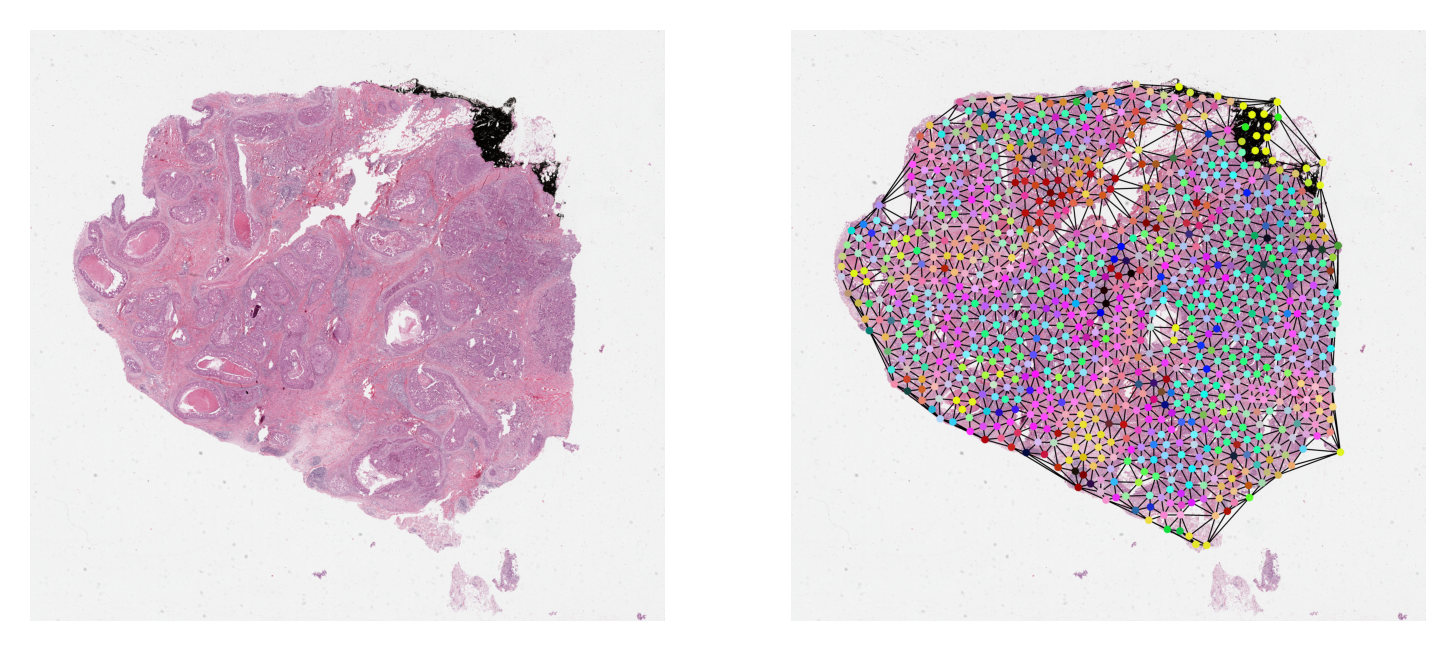

In [37]:
graph_dict = load_json(GRAPH_PATH)
graph_dict = {k: np.array(v) for k, v in graph_dict.items()}
graph = Data(**graph_dict)

# deriving node colors via projecting n-d features down to 3-d
graph.x = StandardScaler().fit_transform(graph.x)
# .c for node colors
node_colors = PCA(n_components=3).fit_transform(graph.x)[:, [1, 0, 2]]
for channel in range(node_colors.shape[-1]):
    node_colors[:, channel] = (
        1 - equalize_hist(node_colors[:, channel]) ** 2
    )
node_colors = (node_colors * 255).astype(np.uint8)

reader = get_wsireader(WSI_PATH)
thumb = reader.slide_thumbnail(4.0, 'mpp')

node_resolution = reader.slide_dimensions(**NODE_RESOLUTION)
plot_resolution = reader.slide_dimensions(**PLOT_RESOLUTION)
fx = np.array(node_resolution) / np.array(plot_resolution)

node_coordinates = np.array(graph.coords) / fx
edges = graph.edge_index.T

thumb = reader.slide_thumbnail(**PLOT_RESOLUTION)
thumb_overlaid = plot_graph(
    thumb.copy(), node_coordinates, edges,
    node_colors=node_colors, node_size=NODE_SIZE
)

plt.subplot(1, 2, 1)
plt.imshow(thumb)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(thumb_overlaid)
plt.axis('off')
plt.show()

## Graph Neural Network

In [38]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BatchNorm1d, Linear, ReLU
from torch_geometric.nn import (
    EdgeConv,
    GINConv,
    global_add_pool,
    global_max_pool,
    global_mean_pool,
)


class SlideGraphArch(nn.Module):
    def __init__(
        self,
        dim_features,
        dim_target,
        layers=[6, 6],
        pooling="max",
        dropout=0.0,
        conv="GINConv",
        gembed=False,
        **kwargs,
    ):
        super().__init__()
        self.dropout = dropout
        self.embeddings_dim = layers
        self.num_layers = len(self.embeddings_dim)
        self.nns = []
        self.convs = []
        self.linears = []
        self.pooling = {
            "max": global_max_pool,
            "mean": global_mean_pool,
            "add": global_add_pool,
        }[pooling]
        # If True then learn a graph embedding for final classification
        # (classify pooled node features), otherwise pool node decision scores.
        self.gembed = gembed

        conv_dict = {"GINConv": [GINConv, 1], "EdgeConv": [EdgeConv, 2]}
        if conv not in conv_dict:
            raise ValueError(f'Not support `conv="{conv}".')

        def create_linear(in_dims, out_dims):
            return nn.Sequential(
                Linear(in_dims, out_dims), BatchNorm1d(out_dims), ReLU()
            )

        input_emb_dim = dim_features
        out_emb_dim = self.embeddings_dim[0]
        self.first_h = create_linear(input_emb_dim, out_emb_dim)
        self.linears.append(Linear(out_emb_dim, dim_target))

        input_emb_dim = out_emb_dim
        for out_emb_dim in self.embeddings_dim[1:]:
            ConvClass, alpha = conv_dict[conv]
            subnet = create_linear(alpha * input_emb_dim, out_emb_dim)
            # ! this variable should be removed after training integrity checking
            self.nns.append(subnet)  # <--| as it already within ConvClass
            self.convs.append(ConvClass(self.nns[-1], **kwargs))
            self.linears.append(Linear(out_emb_dim, dim_target))
            input_emb_dim = out_emb_dim

        self.nns = torch.nn.ModuleList(self.nns)
        self.convs = torch.nn.ModuleList(self.convs)
        # Has got one more for initial input, what does this mean
        self.linears = torch.nn.ModuleList(self.linears)

        # Auxilary holder for external model, these are saved separately from torch.save
        # as they can be sklearn model etc.
        self.aux_model = {}

    def save(self, path, aux_path):
        state_dict = self.state_dict()
        torch.save(state_dict, path)
        joblib.dump(self.aux_model, aux_path)

    def load(self, path, aux_path):
        state_dict = torch.load(path)
        self.load_state_dict(state_dict)
        self.aux_model = joblib.load(aux_path)

    def forward(self, data):

        feature, edge_index, batch = data.x, data.edge_index, data.batch

        wsi_prediction = 0
        pooling = self.pooling
        node_prediction = 0

        feature = self.first_h(feature)
        for layer in range(self.num_layers):
            if layer == 0:
                node_prediction_sub = self.linears[layer](feature)
                node_prediction += node_prediction_sub
                node_pooled = pooling(node_prediction_sub, batch)
                wsi_prediction_sub = F.dropout(
                    node_pooled, p=self.dropout, training=self.training
                )
                wsi_prediction += wsi_prediction_sub
            else:
                feature = self.convs[layer - 1](feature, edge_index)
                if not self.gembed:
                    node_prediction_sub = self.linears[layer](feature)
                    node_prediction += node_prediction_sub
                    node_pooled = pooling(node_prediction_sub, batch)
                    wsi_prediction_sub = F.dropout(
                        node_pooled, p=self.dropout, training=self.training
                    )
                else:
                    node_pooled = pooling(feature, batch)
                    node_prediction_sub = self.linears[layer](node_pooled)
                    wsi_prediction_sub = F.dropout(
                        node_prediction_sub, p=self.dropout, training=self.training
                    )
                wsi_prediction += wsi_prediction_sub
        return wsi_prediction, node_prediction

    # Run one single step
    @staticmethod
    def train_batch(model, batch_data, on_gpu, optimizer: torch.optim.Optimizer):
        wsi_graphs = batch_data["graph"].to("cuda")
        wsi_labels = batch_data["label"].to("cuda")

        # Data type conversion
        wsi_graphs.x = wsi_graphs.x.type(torch.float32)

        # Not an RNN so does not accumulate
        model.train()
        optimizer.zero_grad()

        wsi_output, _ = model(wsi_graphs)

        # Both are expected to be Nx1
        wsi_labels_ = wsi_labels[:, None]
        wsi_labels_ = wsi_labels_ - wsi_labels_.T
        wsi_output_ = wsi_output - wsi_output.T
        diff = wsi_output_[wsi_labels_ > 0]
        loss = torch.mean(F.relu(1.0 - diff))
        # Backprop and update
        loss.backward()
        optimizer.step()

        #
        loss = loss.detach().cpu().numpy()
        assert not np.isnan(loss)
        wsi_labels = wsi_labels.cpu().numpy()
        return [loss, wsi_output, wsi_labels]

    # Run one inference step
    @staticmethod
    def infer_batch(model, batch_data, on_gpu):
        wsi_graphs = batch_data["graph"].to("cuda")

        # Data type conversion
        wsi_graphs.x = wsi_graphs.x.type(torch.float32)

        # Inference mode
        model.eval()
        # Do not compute the gradient (not training)
        with torch.inference_mode():
            wsi_output, _ = model(wsi_graphs)

        wsi_output = wsi_output.cpu().numpy()
        # Output should be a single tensor or scalar
        if "label" in batch_data:
            wsi_labels = batch_data["label"]
            wsi_labels = wsi_labels.cpu().numpy()
            return wsi_output, wsi_labels
        return [wsi_output]

## Inference
Now we load the data, create the model and perform the inference.
Once we obtain the predictions, we calibrate them into proper probabilities
by using a pretrained Platt Scaler which is accessible at `model.aux_model['scaler']`.
The prediction and the probabilities are printed.

In [45]:
from torch_geometric.data import Batch, Data


arch_kwargs = dict(
    dim_features=NUM_NODE_FEATURES,
    dim_target=1,
    layers=[16, 16, 8],
    dropout=0.5,
    pooling="mean",
    conv="EdgeConv",
    aggr="max",
)
node_scaler = joblib.load(SCALER_PATH)

with open(GRAPH_PATH, "r") as fptr:
    graph_dict = json.load(fptr)
graph_dict = {k: np.array(v) for k, v in graph_dict.items()}
graph_dict["x"] = node_scaler.transform(graph_dict["x"])
graph_dict = {k: torch.tensor(v) for k, v in graph_dict.items()}
graph = Data(**graph_dict)
batch = Batch.from_data_list([graph])

model = SlideGraphArch(**arch_kwargs)
model.load(MODEL_WEIGHTS_PATH, MODEL_AUX_PATH)
model = model.to('cuda')

# Data type conversion
with torch.inference_mode():
    batch = batch.to('cuda')
    batch.x = batch.x.type(torch.float32)
    predictions, node_activations = model(batch)
    predictions = predictions.detach().cpu().numpy()
    probabilities = model.aux_model['scaler'].transform(predictions)
    print(f"Prediction: {predictions}")
    print(f"Probabilities: {probabilities}")
    node_activations = node_activations.detach().cpu().numpy()

Prediction: [[0.00365531]]
Probabilities: [[0.12280393]]


## Visualize Node Activation of Graph Neural Network

Visualizing the activations of each node within the graph is sometimes necessary to either debug or
verify the predictions of the graph neural network. Here, we demonstrate

1. Load pretrained model and run inference on one single sample graph.
2. Retrieve the node activations and plot them on the original WSI.

By default, notice that node activations are also output when running `mode.forward(input)` (or
simply `model(input)` in pytorch).

Most of the time the nodes within the graph will be at a different resolution
from the resolution at which we want to visualize them. Before plotting, we scale their coordinates
to the target resolution. We provide `NODE_RESOLUTION` and `PLOT_RESOLUTION` variables
respectively as the resolution of the node and the resolution to plot the graph.

In [28]:
NODE_SIZE = 25
NUM_NODE_FEATURES = 4
NODE_RESOLUTION = dict(resolution=0.5, units='mpp')
PLOT_RESOLUTION = dict(resolution=4.0, units='mpp')

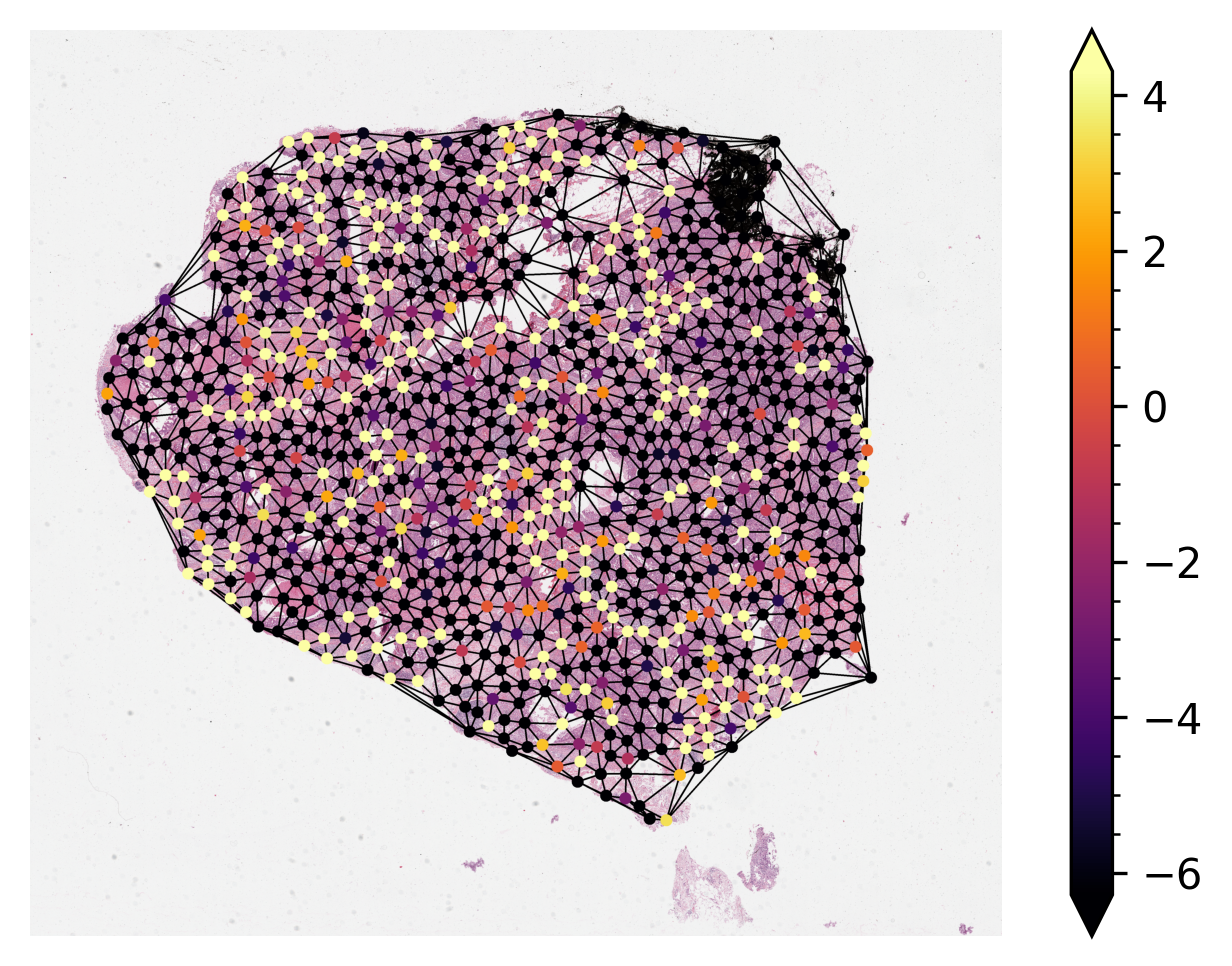

In [29]:
cmap = plt.get_cmap('inferno')
graph = graph.to('cpu')

node_coordinates = np.array(graph.coords) / fx
node_colors = (
    cmap(np.squeeze(node_activations))
        [..., :3] * 255).astype(np.uint8
)
edges = graph.edge_index.T

thumb = reader.slide_thumbnail(**PLOT_RESOLUTION)
thumb_overlaid = plot_graph(
    thumb.copy(), node_coordinates, edges,
    node_colors=node_colors, node_size=NODE_SIZE
)

ax = plt.subplot(1, 1, 1)
plt.imshow(thumb_overlaid)
plt.axis('off')
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
fig = plt.gcf()
norm = mpl.colors.Normalize(
    vmin=np.min(node_activations),
    vmax=np.max(node_activations)
)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, extend='both')
cbar.minorticks_on()
plt.show()
